In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset source : https://www.kaggle.com/datasets/cpluzshrijayan/milkquality

In [40]:
df=pd.read_csv(r"milknew.csv")

df.info() # all non null values ;}

df=df.rename(columns={'Temprature':'Temp','Fat ':'Fat'}) # renaming a mispelled column to shortened form; 
# column with a space to a column with none

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [41]:
df['Grade'].value_counts() # low med and high values aren't thaaaaaat imbalanced; will deem it acceptable for now

low       429
medium    374
high      256
Name: Grade, dtype: int64

In [42]:
print(df.dtypes)
df.head() # yeah essentially all values (apart from Grade) are numeric

pH           float64
Temp           int64
Taste          int64
Odor           int64
Fat            int64
Turbidity      int64
Colour         int64
Grade         object
dtype: object


,pH,Temp,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [43]:
df['Grade']=df['Grade'].map({'low':0,'medium':1,'high':2}) # map categorical values in 'Grade' column to integer values
# data is ordinal in nature

from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(df[df.columns.drop('Grade')],df['Grade'],stratify=df['Grade'],random_state=42)
# data will first be split before any preprocessing/ training is conducted to prevent data leakage

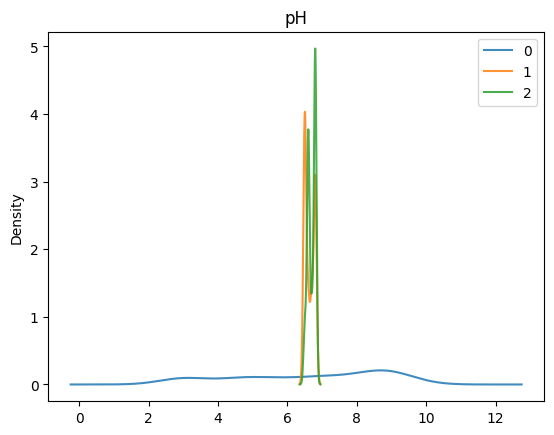

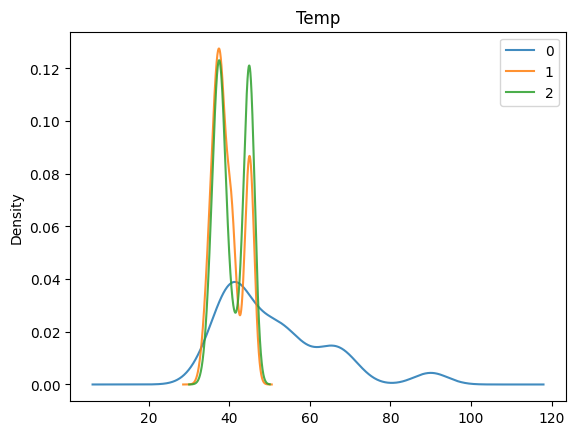

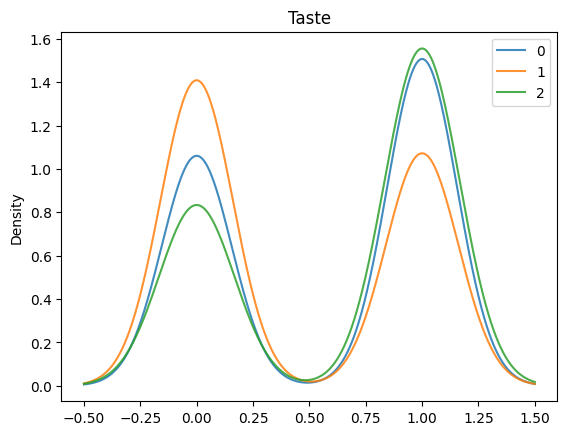

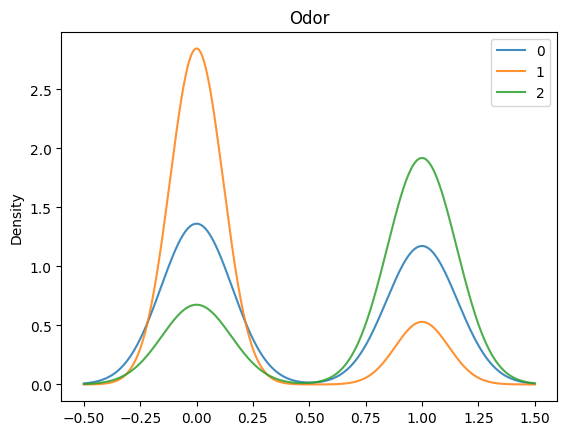

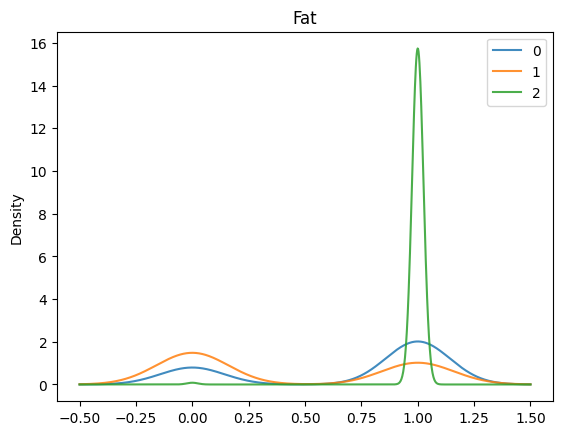

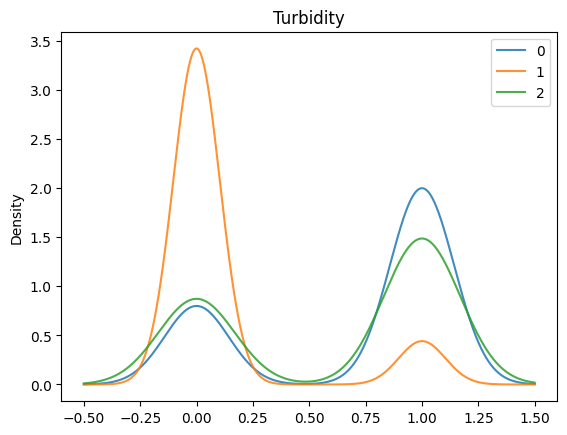

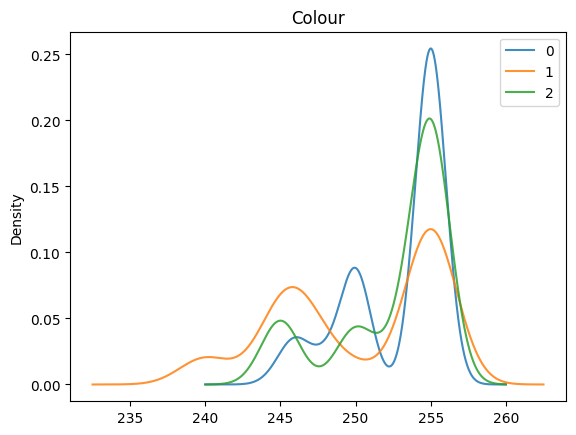

In [44]:
train_dataset=pd.concat([X_train,y_train],axis=1)
for c in train_dataset:
    if c=='Grade':
        continue
    train_dataset.groupby('Grade')[c].plot(kind='kde',alpha=0.85)
    plt.legend(train_dataset.groupby('Grade').mean().index)
    plt.title(c)
    plt.show()

In [45]:
# conclusions; for rating to be medium/high; pH must be strictly within a certain range (seems like 6-7); outisde is likely to be low
# if fatness is optimally satisfied, very likely to be highly rated
# lack of turbidity and odor (and potentially taste) could prove to be medium

# Let's see how the logic holds up based on the assumptions above

In [46]:
# based on input data, see if pH range is in between 6 and 7  (if not Grade 0)
# else if Fat is 1, high
# else if taste, odor and turbidity are mostly 0> medium
def pred_milk_qual(df):
    pred=[]
    for _,r in df.iterrows():
        if r['pH']<6 or r['pH']>7:
            pred.append(0)
        elif sum([r['Taste'],r['Odor'],r['Turbidity']])<=1:
            pred.append(1)
        elif r['Fat']==1:
            pred.append(2)
        else:
            pred.append(0)
    return pd.Series(pred)

y_pred=pred_milk_qual(X_train)
(y_pred[y_pred.reset_index(drop=True)==y_train.reset_index(drop=True)].value_counts())/y_train.value_counts()
# not perfect for high, but overall p good

0    0.888199
1    0.885714
2    0.687500
dtype: float64

In [47]:
y_pred=pred_milk_qual(X_test)
(y_pred[y_pred.reset_index(drop=True)==y_test.reset_index(drop=True)].value_counts())/y_test.value_counts()

# ok, actl performs fairly decently for low and medium, but not as well (as well as it could be) for 'high' class (2)
# does show that decision tree logic does work; and will hence use that as a model for classification

0    0.878505
1    0.872340
2    0.750000
dtype: float64

              precision    recall  f1-score   support

         low       1.00      0.97      0.99       107
      medium       0.98      1.00      0.99        94
        high       0.97      0.98      0.98        64

    accuracy                           0.98       265
   macro avg       0.98      0.99      0.98       265
weighted avg       0.99      0.98      0.98       265



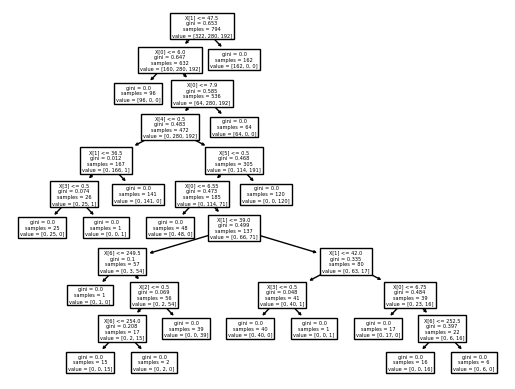

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report

model=DecisionTreeClassifier()

model.fit(X_train,y_train)
plot_tree(model)

y_pred=model.predict(X_test)

print(classification_report(y_test,y_pred,target_names=['low','medium','high'])) # now that's good
# but it is ofc subject to change based on the random state of the split